# Sección 2. Quién es quién

Descarga la Base de datos histórica de Quién es Quién en los Precios de Profeco y resuelve los
siguientes incisos. Para el procesamiento de los datos y el análisis exploratorio debes debes
usar Spark SQL, preferentemente, con Python.

1. Procesamiento de los datos

    a. ¿Cuántos registros hay?
    b. ¿Cuántas categorías?
    c. ¿Cuántas cadenas comerciales están siendo monitoreadas?
    d. ¿Cómo podrías determinar la calidad de los datos? ¿Detectaste algún tipo de
    inconsistencia o error en la fuente?
    e. ¿Cuáles son los productos más monitoreados en cada entidad?
    f. ¿Cuál es la cadena comercial con mayor variedad de productos monitoreados?
    
2. Análisis exploratorio
    a. Genera una canasta de productos básicos que te permita comparar los precios
    geográfica y temporalmente. Justifica tu elección y procedimiento
    b. ¿Cuál es la ciudad más cara del país?¿Cuál es la más barata?
    c. ¿Hay algún patrón estacional entre años?
    d. ¿Cuál es el estado más caro y en qué mes?
    e. ¿Cuáles son los principales riesgos de hacer análisis de series de tiempo con
    estos datos?
    
3. Visualización
    a. Genera un mapa que nos permita identificar la oferta de categorías en la zona
    metropolitana de León Guanajuato y el nivel de precios en cada una de ellas. Se
    darán puntos extra si el mapa es interactivo

# Librerías, sesión y datos

In [52]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
spark = SparkSession.builder.appName('opi').master("local[*]").getOrCreate()

In [5]:
spark.version

'3.1.2'

In [6]:
path_profeco = 'data/profeco/all_data.csv'

In [7]:
profeco = spark.read.csv(path_profeco,sep=',',header=True)

In [9]:
profeco.printSchema()

root
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: string (nullable = true)
 |-- fechaRegistro: string (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombreComercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)



# Cuestionario

## Procesamiento de los datos

### a. ¿Cuántos registros hay?

In [10]:
profeco.count()

35559916

### b. ¿Cuántas categorías?

In [13]:
profeco.cache()

DataFrame[producto: string, presentacion: string, marca: string, categoria: string, catalogo: string, precio: string, fechaRegistro: string, cadenaComercial: string, giro: string, nombreComercial: string, direccion: string, estado: string, municipio: string, latitud: string, longitud: string]

In [20]:
profeco.select('categoria').distinct().count()

41

### c. ¿Cuántas cadenas comerciales están siendo monitoreadas?

In [21]:
profeco.select('cadenaComercial').distinct().count()

607

### d. ¿Cómo podrías determinar la calidad de los datos? ¿Detectaste algún tipo de inconsistencia o error en la fuente?

In [22]:
profeco.printSchema()

root
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: string (nullable = true)
 |-- fechaRegistro: string (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombreComercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)



1. Identificador llave única
2. Tipos de datos acorde al negocio
3. Variables categóricas sigan un estándar, de preferencia que exista un diccionario de datos para confirmar el cumplimiento
4. Fechas registo a partir de 2015
5. Precio con el mismo tipo de cambio
6. Detección de outliers para precio acorde al precios históricos por producto
7. Latitud y longitud entre -90,90 y -180,180 respectivamente.
8. Ubicar las columnas que no hagan sentido que tengan missing values (ejemplo, precios, nombre de producto, fecha de registro, etc)
9. La suma de producto únicos debe ser igual a 2000


In [24]:
profeco.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------+--------------------+------------------+------------------+
|summary|            producto|        presentacion|               marca|           categoria|        catalogo|            precio|       fechaRegistro| cadenaComercial|                giro|     nombreComercial|           direccion|        estado|           municipio|           latitud|          longitud|
+-------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------+--------------------+------------------+------------------+
|  count|            35559916|            35559916|            35559916|            3

Problemas detectados para calidad de datos:

* Hay registros menores al 2015, por lo cual no siguen la descripción de la tabla dada en la paltaforma
* Posible outlier para precio (99999)

### e. ¿Cuáles son los productos más monitoreados en cada entidad?

In [43]:
profeco_estado = profeco.groupBy(['producto','estado']).count()

In [47]:
profeco_estado.sort(profeco_estado["count"].desc()).show(truncate=False)

+-----------------------+----------------+------+
|producto               |estado          |count |
+-----------------------+----------------+------+
|REFRESCO               |DISTRITO FEDERAL|167433|
|FUD                    |DISTRITO FEDERAL|125314|
|DETERGENTE P/ROPA      |DISTRITO FEDERAL|124266|
|LECHE ULTRAPASTEURIZADA|DISTRITO FEDERAL|116485|
|REFRESCO               |MÉXICO          |114390|
|DETERGENTE P/ROPA      |MÉXICO          |95734 |
|FUD                    |MÉXICO          |89881 |
|MAYONESA               |DISTRITO FEDERAL|87744 |
|YOGHURT                |DISTRITO FEDERAL|86456 |
|CHILES EN LATA         |DISTRITO FEDERAL|86003 |
|CERVEZA                |DISTRITO FEDERAL|85369 |
|JABON DE TOCADOR       |DISTRITO FEDERAL|84010 |
|SHAMPOO                |DISTRITO FEDERAL|81310 |
|LECHE ULTRAPASTEURIZADA|MÉXICO          |77060 |
|LECHE EN POLVO         |DISTRITO FEDERAL|74743 |
|TOALLA FEMENINA        |DISTRITO FEDERAL|69730 |
|HUEVO                  |DISTRITO FEDERAL|68476 |


### f. ¿Cuál es la cadena comercial con mayor variedad de productos monitoreados?

In [55]:
profeco_cadcom_prod = profeco.groupBy("cadenaComercial").agg(f.countDistinct("producto"))
profeco_cadcom_prod.sort(profeco_cadcom_prod["count(producto)"].desc()).show(1,truncate=False)

+---------------+---------------+
|cadenaComercial|count(producto)|
+---------------+---------------+
|SORIANA        |1037           |
+---------------+---------------+
only showing top 1 row



## Análisis exploratorio

In [ ]:
2. Análisis exploratorio
    a. Genera una canasta de productos básicos que te permita comparar los precios
    geográfica y temporalmente. Justifica tu elección y procedimiento
    b. ¿Cuál es la ciudad más cara del país?¿Cuál es la más barata?
    c. ¿Hay algún patrón estacional entre años?
    d. ¿Cuál es el estado más caro y en qué mes?
    e. ¿Cuáles son los principales riesgos de hacer análisis de series de tiempo con
    estos datos?

### a. Genera una canasta de productos básicos que te permita comparar los precios  geográfica y temporalmente. Justifica tu elección y procedimiento

1. Los que más ventas tienen
2. Más periodos de ventas (aniomes)
3. Se encuentran en la mayoría de los estados

In [85]:
producto_ventas = profeco.filter(f.col("catalogo") == 'BASICOS').groupBy("producto","catalogo").agg(f.count("producto"))
producto_ventas = producto_ventas.sort(producto_ventas["count(producto)"].desc())

In [86]:
producto_ventas.show()

+--------------------+--------+---------------+
|            producto|catalogo|count(producto)|
+--------------------+--------+---------------+
|            REFRESCO| BASICOS|         606666|
|LECHE ULTRAPASTEU...| BASICOS|         544650|
|   DETERGENTE P/ROPA| BASICOS|         536527|
|                 FUD| BASICOS|         445940|
|      CHILES EN LATA| BASICOS|         410854|
|             SHAMPOO| BASICOS|         403600|
|            MAYONESA| BASICOS|         368412|
|             YOGHURT| BASICOS|         351895|
|     TOALLA FEMENINA| BASICOS|         338932|
|         DESODORANTE| BASICOS|         327034|
|      LECHE EN POLVO| BASICOS|         323104|
|             CERVEZA| BASICOS|         311614|
|         PAN DE CAJA| BASICOS|         286954|
|              ACEITE| BASICOS|         281605|
|        AGUA SIN GAS| BASICOS|         273015|
|    JABON DE TOCADOR| BASICOS|         269153|
|       CREMA LIQUIDA| BASICOS|         245520|
| INSECTICIDA AEROSOL| BASICOS|         

In [87]:
producto_ventas.count()

195

In [88]:
producto_ventas = producto_ventas.toPandas()  # symboling is the column for histogram

<AxesSubplot:ylabel='Frequency'>

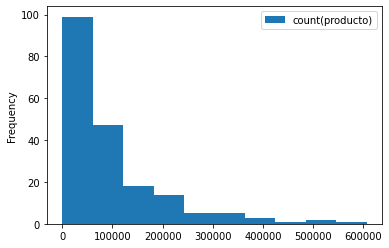

In [89]:
producto_ventas.plot(kind='hist')

Como primer filtro, tomaremos los productos que más registros tienen haciendo un corte

In [139]:
profeco.printSchema()

root
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: string (nullable = true)
 |-- fechaRegistro: string (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombreComercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)



In [140]:
producto_ventas[producto_ventas['count(producto)']>=200000]

,producto,catalogo,count(producto)
0,REFRESCO,BASICOS,606666
1,LECHE ULTRAPASTEURIZADA,BASICOS,544650
2,DETERGENTE P/ROPA,BASICOS,536527
3,FUD,BASICOS,445940
4,CHILES EN LATA,BASICOS,410854
5,SHAMPOO,BASICOS,403600
6,MAYONESA,BASICOS,368412
7,YOGHURT,BASICOS,351895
8,TOALLA FEMENINA,BASICOS,338932
9,DESODORANTE,BASICOS,327034


In [152]:
ls_productos = producto_ventas.producto.unique().tolist()

In [94]:
profeco.show(1)

+--------------------+--------------------+--------+----------------+----------------+------+--------------------+------------------+----------+--------------------+--------------------+----------------+--------------------+--------+----------+
|            producto|        presentacion|   marca|       categoria|        catalogo|precio|       fechaRegistro|   cadenaComercial|      giro|     nombreComercial|           direccion|          estado|           municipio| latitud|  longitud|
+--------------------+--------------------+--------+----------------+----------------+------+--------------------+------------------+----------+--------------------+--------------------+----------------+--------------------+--------+----------+
|CUADERNO FORMA IT...|96 HOJAS PASTA DU...|ESTRELLA|MATERIAL ESCOLAR|UTILES ESCOLARES|  25.9|2011-05-18 00:00:...|ABASTECEDORA LUMEN|PAPELERIAS|ABASTECEDORA LUME...|CANNES No. 6 ESQ....|DISTRITO FEDERAL|TLALPAN          ...|19.29699|-99.125417|
+-------------------

In [119]:
profeco.select("fechaRegistro").show(1)

+--------------------+
|       fechaRegistro|
+--------------------+
|2011-05-18 00:00:...|
+--------------------+
only showing top 1 row



In [181]:
len(ls_productos)

195

In [162]:
profeco_ = profeco.withColumn("fecha",f.to_date("fechaRegistro","yyyy-MM-dd HH:mm:ss.SSS"))

In [163]:
profeco_ = profeco_.filter(f.col("producto").isin(ls_productos))

In [164]:
profeco_ = profeco_.withColumn("fecha_aniomes",f.date_format("fecha","yyyy-MM"))

In [166]:
profeco_.select("fecha_aniomes").show()

+-------------+
|fecha_aniomes|
+-------------+
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
|      2011-01|
+-------------+
only showing top 20 rows



In [156]:
profeco_.count()

20517428

Filtrar productos con mínimo 48 meses de ventas

In [178]:
profeco_aniomes = profeco_.groupBy("producto").agg(f.countDistinct("fecha_aniomes"))
profeco_aniomes = profeco_aniomes.sort(profeco_aniomes["count(fecha_aniomes)"].desc())
profeco_aniomes = profeco_aniomes.filter(profeco_aniomes["count(fecha_aniomes)"]>=48)

In [179]:
profeco_aniomes.show()

+--------------------+--------------------+
|            producto|count(fecha_aniomes)|
+--------------------+--------------------+
|                FLAN|                  48|
|               IBERO|                  48|
|LECHE ULTRAPASTEU...|                  48|
|REPUESTOS DE NAVAJAS|                  48|
|     PIÑA EN ALMIBAR|                  48|
|          CHILE SECO|                  48|
|        AGUA SIN GAS|                  48|
|               AVENA|                  48|
|CAFE TOSTADO Y MO...|                  48|
|            GALLETAS|                  48|
|  LECHE PASTEURIZADA|                  48|
|     QUESO DE PUERCO|                  48|
|       MAIZ POZOLERO|                  48|
|       SALSA PICANTE|                  48|
|         NOCHE BUENA|                  48|
|    SAN RAFAEL. REAL|                  48|
|    ACEITUNA. GORDAL|                  48|
|            GARBANZA|                  48|
|            FRIJOLES|                  48|
|               JAMON|          

In [180]:
profeco_aniomes.count()

167

In [188]:
ls_productos = profeco_aniomes.select("producto").distinct()

In [189]:
ls_productos = [row.producto for row in ls_productos.collect()]

In [191]:
profeco_ = profeco_.filter(f.col("producto").isin(ls_productos))

In [193]:
profeco_.count()

20101308

In [195]:
profeco_.printSchema()

root
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: string (nullable = true)
 |-- fechaRegistro: string (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombreComercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)
 |-- fecha: date (nullable = true)
 |-- fecha_aniomes: string (nullable = true)



Filtrar aquellos productos que han estado en las 32 entidades

In [198]:
estado = profeco_.groupBy("producto").agg(f.countDistinct("estado"))
estado = estado.sort(estado["count(estado)"].desc())
estado = estado.filter(estado["count(estado)"]>=32)

In [199]:
estado.show()

+--------------------+-------------+
|            producto|count(estado)|
+--------------------+-------------+
|    TORTILLA DE MAIZ|           33|
|  PAN BLANCO BOLILLO|           33|
|                FLAN|           32|
|     PIÑA EN ALMIBAR|           32|
|            GALLETAS|           32|
|       SALSA PICANTE|           32|
|        AGUA SIN GAS|           32|
|               AVENA|           32|
|LECHE ULTRAPASTEU...|           32|
|         CARNE POLLO|           32|
|       MAIZ POZOLERO|           32|
|CAFE TOSTADO Y MO...|           32|
|            GARBANZA|           32|
|            FRIJOLES|           32|
|    SAN RAFAEL. REAL|           32|
|    ACEITUNA. GORDAL|           32|
|     PAPEL HIGIENICO|           32|
|         CARNE CERDO|           32|
|                 FUD|           32|
|ACEITUNA. MANZANILLA|           32|
+--------------------+-------------+
only showing top 20 rows



In [200]:
ls_productos = estado.select("producto").distinct()
ls_productos = [row.producto for row in ls_productos.collect()]

In [202]:
len(ls_productos)

141

In [203]:
profeco_ = profeco_.filter(profeco_["producto"].isin(ls_productos))

In [204]:
profeco_.count()

19416867

Nos quedamos con 141 productos para la canasta básica con los 3 criterios descritos anteriorimente

In [205]:
profeco_.printSchema()

root
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: string (nullable = true)
 |-- fechaRegistro: string (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombreComercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)
 |-- fecha: date (nullable = true)
 |-- fecha_aniomes: string (nullable = true)



### b. ¿Cuál es la ciudad más cara del país?¿Cuál es la más barata?

### c. ¿Hay algún patrón estacional entre años?

### d. ¿Cuál es el estado más caro y en qué mes?

### e. ¿Cuáles son los principales riesgos de hacer análisis de series de tiempo con estos datos?

## Visualización    

### a. Genera un mapa que nos permita identificar la oferta de categorías en la zona metropolitana de León Guanajuato y el nivel de precios en cada una de ellas. Se darán puntos extra si el mapa es interactivo